In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# IMPORT
import pandas as pd
import numpy as np
import re
from datetime import datetime

# Project-specific modules
from olist.data import *
from olist.utils import *
from olist.visualisation import *

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import folium.plugins as plugins

# By Location

In [3]:
data = Olist().get_data()
sellers = data['sellers']
geolocation = data['geolocation']
customers = data['customers']

In [4]:
orders = data['orders']


In [5]:
geo_by_zip_code = geolocation.groupby('geolocation_zip_code_prefix')\
                                .agg({'geolocation_lat':'mean', 'geolocation_lng': 'mean'})

In [6]:
order_items= data['order_items']

In [7]:
order_payments = data['order_payments']

## Sellers

<AxesSubplot:xlabel='id', ylabel='state'>

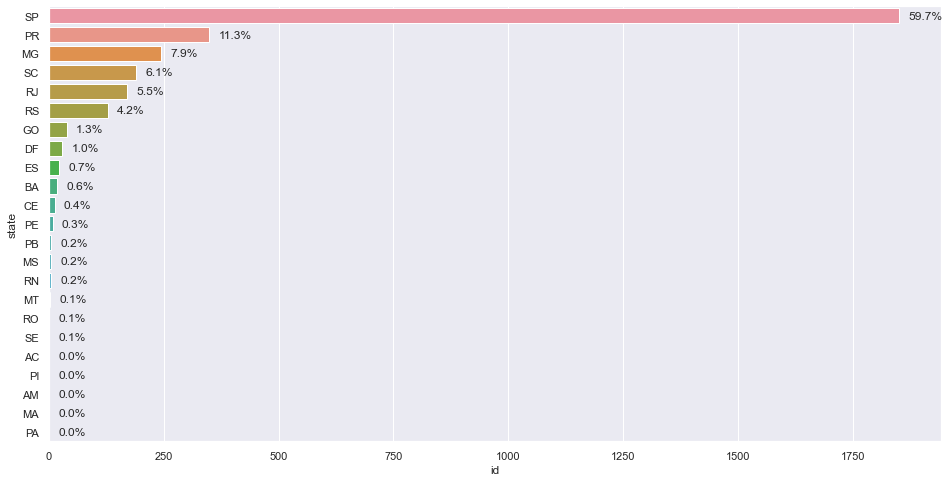

In [8]:
sellers_by_state = count_p_location(sellers, ['seller_state','seller_id'], 'state')
plot_by_state(sellers_by_state)

In [9]:
sellers_by_zip_code= count_p_location(sellers, ['seller_zip_code_prefix','seller_id'], 'zip_code')
plot_cluster(sellers_by_zip_code)

## Customers

<AxesSubplot:xlabel='id', ylabel='state'>

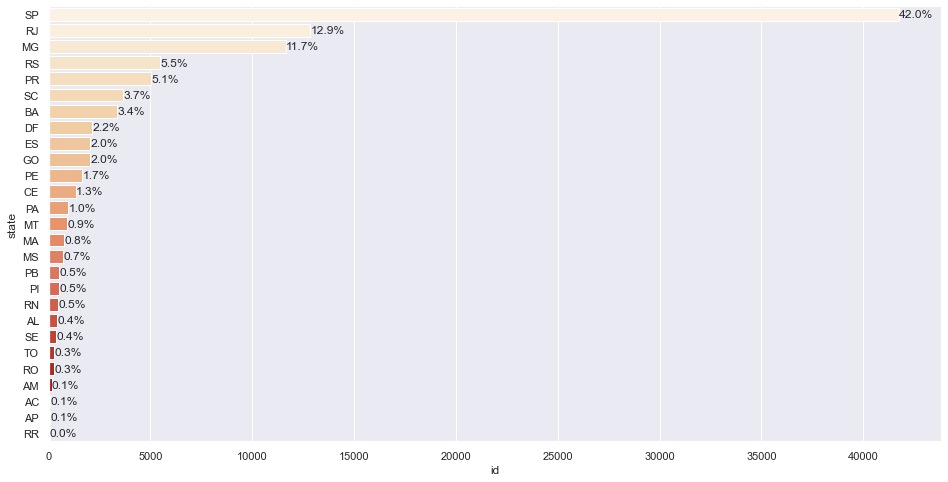

In [10]:
customers_by_state = count_p_location(customers, ['customer_state','customer_id'], 'state')
plot_by_state(customers_by_state, palette= 'OrRd')

In [11]:
customers_by_zip_code = count_p_location(customers, ['customer_zip_code_prefix','customer_id'], 'zip_code')
plot_cluster(customers_by_zip_code)

## Orders

### Orders by Location

In [12]:
orders_geo = orders[['order_id','customer_id']]\
                .merge(customers[['customer_id','customer_zip_code_prefix','customer_state']], 
                        left_on= "customer_id", 
                        right_on='customer_id')\
                .merge(geo_by_zip_code,
                        left_on='customer_zip_code_prefix',
                        right_on='geolocation_zip_code_prefix')


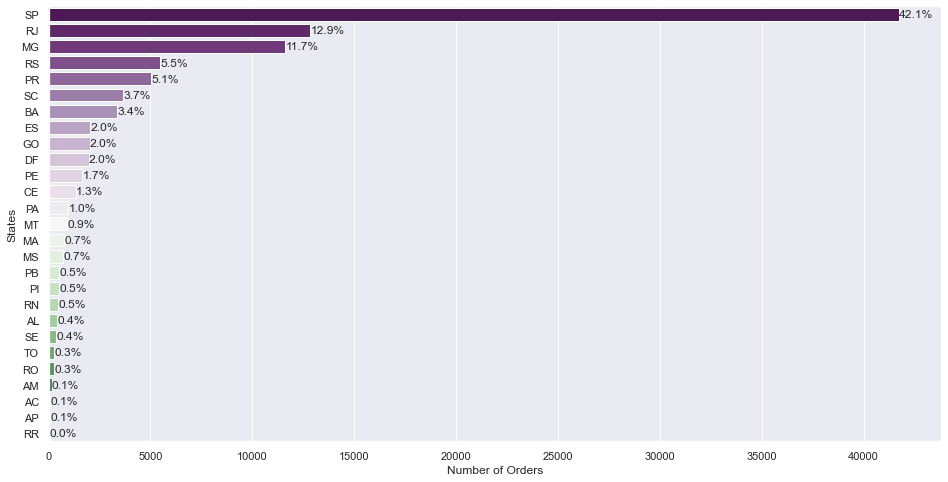

In [13]:
orders_by_state = count_p_location(orders_geo, ['customer_state','order_id'], 'state')
plot1 = plot_by_state(orders_by_state, palette= 'PRGn')
plot1.set_ylabel("States")
plot1.set_xlabel("Number of Orders");

In [14]:
orders_by_zip_code = count_p_location(orders_geo, ['customer_zip_code_prefix','order_id'], 'zip_code')
plot_cluster(orders_by_zip_code)

### Order Values

In [15]:
orders['order_approved_date'] = orders['order_purchase_timestamp'].apply(
    lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y%m'))


In [16]:
orders= orders.merge(order_payments[['order_id','payment_value']],
             left_on= 'order_id',
             right_on= 'order_id')

In [17]:
orders_over_time = orders[['order_id','order_approved_date','payment_value']]\
                    .groupby(by= 'order_approved_date')\
                    .agg({'order_id': 'count', 'payment_value': 'sum'})\
                    .sort_values(by= 'order_approved_date', ascending = True)

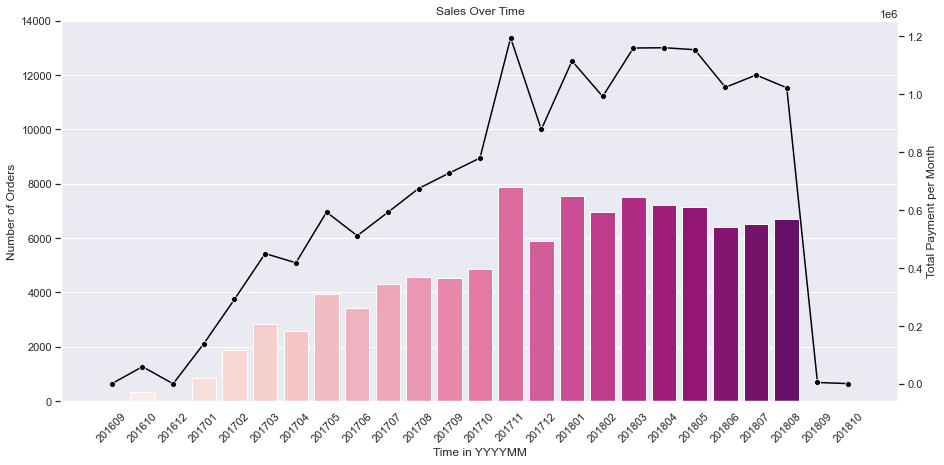

In [100]:
# set dimensions of figure
sns.set(rc={'figure.figsize':(15,7)})

# ###########################
# "number of orders" barplot
#############################
p = sns.barplot(x= orders_over_time.index,
               y = 'order_id',
               data = orders_over_time,
               palette= 'RdPu')
p.set(title='Sales Over Time')
p.set_ylabel("Number of Orders")
p.set_xlabel("Time in YYYYMM")
p.set_ylim(0,14000)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
# x = 0
# for patch, quantity in zip(p.patches, orders_over_time.iloc[:,0]):   # for each patch/bar
#     y = patch.get_height() + 50                                           # offset 50 from top of bar
#     p.annotate(quantity,(x,y),horizontalalignment="center")
#     x += 1

####################
# Create second axis
####################
ax2 = plt.twinx()
sns.lineplot(data=orders_over_time.payment_value, 
             color="black", 
             marker = "o",
             ax=ax2)
ax2.grid(False)

ax2.set_ylabel('Total Payment per Month');


In [82]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# convert string to date time, displayed in day of week format
orders['order_day']= pd.to_datetime(orders.order_purchase_timestamp).dt.day_name()

orders_by_weekday = orders[['order_id','order_day','payment_value']]\
                    .groupby(by= 'order_day')\
                    .agg({'order_id': 'count', 'payment_value': 'sum'})\
                    .sort_values('order_day',ascending= True)

orders_by_weekday= orders_by_weekday.reindex(cats)


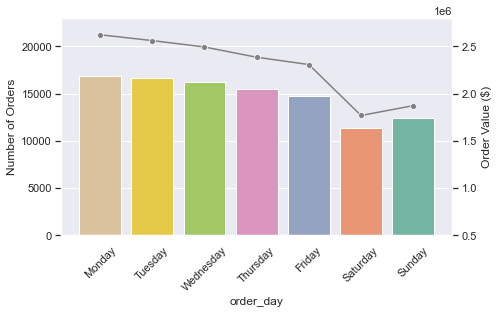

In [99]:
sns.set(rc={'figure.figsize':(7,4)})

# ###########################
# "number of orders" barplot
#############################
plot2 = sns.barplot(x= orders_by_weekday.index,
               y = 'order_id',
               data = orders_by_weekday,
               palette= 'Set2_r',)
# plot2.set(title='Sales Over Time')
plot2.set_ylabel("Number of Orders")
plot2.set_ylim(0,23000)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);

# ###########################
# "Order Value" Line Plot
#############################
ax2 = plt.twinx()
sns.lineplot(data=orders_by_weekday.payment_value, 
             color="grey", dashes= '-.', marker= "o", # use "marker =" not "markers = "
             ax=ax2)
ax2.grid(False)
ax2.set_ylim(0.5e6,2.8e6)
ax2.set_ylabel('Order Value ($)');